In [1]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import numpy as np


# clustering

In [107]:
import pickle

with open("./FL-MG-z.pk", 'rb') as f:
    z_FL=pickle.load( f)

embedding_data = z_FL

linked = linkage(embedding_data, 'ward')

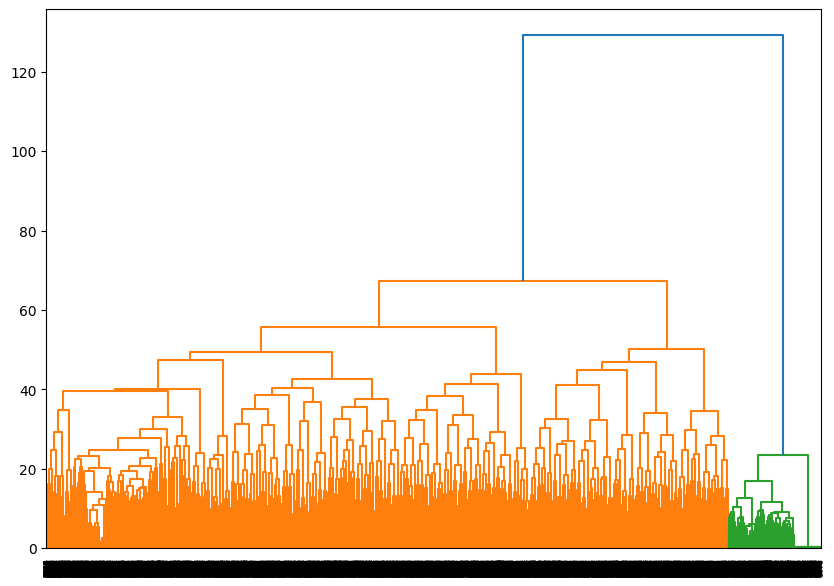

In [12]:
plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()


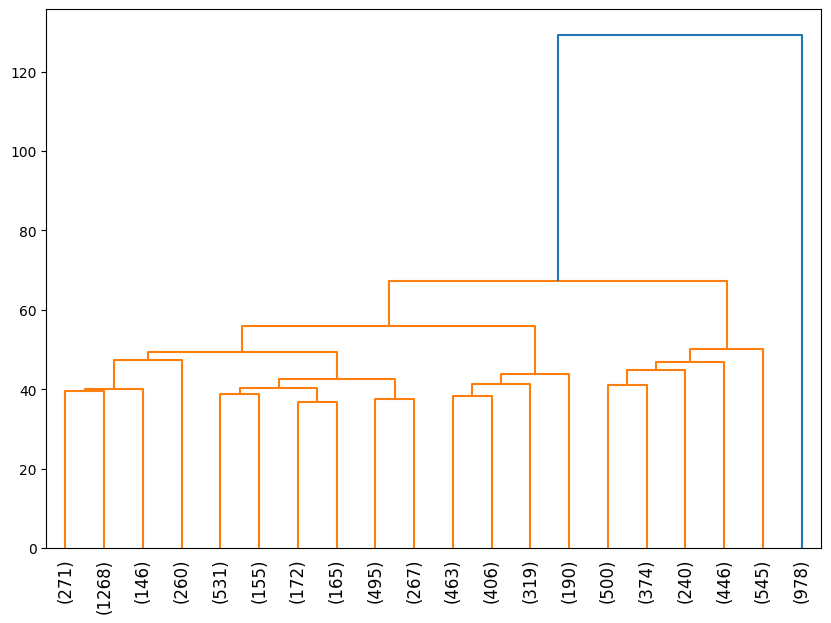

In [16]:
plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top',
           truncate_mode='lastp',  # show only the last p merged clusters
           p=20,  # show only the last 10 merged clusters
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(rotation=90)
plt.show()


In [85]:
from scipy.cluster.hierarchy import fcluster

max_d = 60 # this is the maximum distance between two clusters
membership = fcluster(linked, max_d, criterion='distance')
print("%d clusters identified"%max(membership))

3 clusters identified


In [108]:
from sklearn.cluster import KMeans
import numpy as np

# Assume we have the following 2D data:
X = z_FL

kmeans = KMeans(n_clusters=15, random_state=0)

# Perform k-means clustering
kmeans.fit(X)

membership= kmeans.labels_+1

# Print out the labels
print(max(membership))

/home/csj/micromamba/envs/r430py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15


In [109]:
# loading gene expression time series
ExprPath = "FL-time_series.csv"
import pandas as pd
time_series = pd.read_csv(ExprPath, index_col=0)



gene_membership = pd.DataFrame({'genes':time_series.index, "module_id":membership}).sort_values('module_id')

gene_membership = pd.merge(left=gene_membership, 
         right=pd.DataFrame(time_series.sum(axis=1), columns=['expr_sum']), 
         left_on='genes',right_index=True,how='left'
        )

gene_membership = pd.merge(left=gene_membership, 
         right=pd.DataFrame(time_series.max(axis=1), columns=['expr_max']), 
         left_on='genes',right_index=True,how='left'
        )

from scipy.signal import find_peaks
peak_pos = []
for gene in gene_membership.genes:
    pos, _ = find_peaks(time_series.loc[gene], height=0.1, width=3)
    pos = np.mean(pos) if len(pos)>0 else np.nan
    peak_pos.append(pos)
gene_membership['peak_pos'] = peak_pos

modules = gene_membership.groupby('module_id')['genes'].unique()

module_info = pd.DataFrame({'module_id':modules.index, 
                            'module_size':[len(mod)for mod in modules],
                            'member':modules})
module_info = pd.merge(
    module_info, 
    gene_membership.groupby('module_id').mean(numeric_only=True),
    left_index=True, right_index=True
)

module_info = pd.merge(
    module_info, 
    gene_membership.groupby('module_id').std(numeric_only=True).iloc[:,2],
    left_index=True, right_index=True
)

module_info.columns= ['module_id', 'module_size', 'member', 
                      'mean_expr', 'mean_height','peakpos_mean','peakpos_std']



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP

data = z_FL
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data)

# First, apply PCA
#pca = PCA(n_components=50)
#data_pca = pca.fit_transform(data_scaled)

# Then, apply UMAP
umap = UMAP(n_components=2, min_dist=0.2)
#data_umap = umap.fit_transform(data_pca)
data_umap = umap.fit_transform(data)

gene_membership['umap_1']= data_umap[:, 0]
gene_membership['umap_2']= data_umap[:, 1]


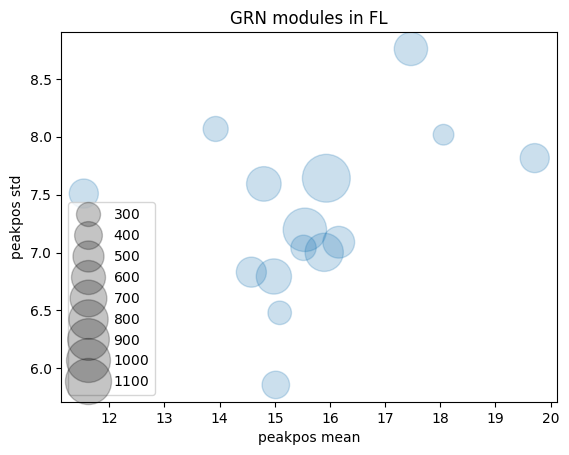

In [101]:

sc=plt.scatter(x=module_info['peakpos_mean'], 
               y=module_info['peakpos_std'],s=module_info['module_size'],alpha=0.23)
plt.ylabel('peakpos std'); plt.xlabel('peakpos mean')
plt.legend(*sc.legend_elements("sizes", num=6))
plt.title("GRN modules in FL")
plt.show()

In [110]:
module_info

,module_id,module_size,member,mean_expr,mean_height,peakpos_mean,peakpos_std
module_id,,,,,,,
1,1,523,"[Chd2, Gon4l, Tango2, Zfp637, Dhps, Dnajc24, C...",7.548042,0.441407,16.159826,7.089479
2,2,978,"[Brd1, Rom1, Endog, Srrm2, Tmem33, Acp5, Asxl1...",9.091975,0.454168,15.546122,7.196689
3,3,469,"[Rrm1, H2afz, Pbk, Timm17a, Rrm2, Hsp90aa1, Cd...",22.965746,0.943499,14.575686,6.831010
4,4,758,"[Tmco6, 2700062C07Rik, Tmem135, Map3k4, Cggbp1...",7.193320,0.365404,15.896239,7.002351
5,5,643,"[Dph2, Mrpl37, Hp1bp3, Rpl9, Leprot, Lrrc42, C...",9.021856,0.467406,14.984123,6.793625
6,6,577,"[6230400D17Rik, Oas1a, Itpr2, Tpcn1, 2810408A1...",1.812211,0.167641,17.467896,8.758509
7,7,325,"[Efcab14, Pde6d, Knl1, Aqp9, A630001G21Rik, Cy...",1.432222,0.171484,13.929245,8.067406
8,8,620,"[Zfp608, Tm7sf2, Topbp1, Mef2d, Il4ra, Abcg2, ...",3.322689,0.221516,14.802227,7.592838
9,9,1187,"[Tmem164, 4932422M17Rik, Mrpl48, Hook1, Iqgap1...",4.885885,0.276854,15.934597,7.641834


In [111]:
gene_membership.head(50)

,genes,module_id,expr_sum,expr_max,peak_pos,umap_1,umap_2
6556,Chd2,1,1.758225,0.216489,NaN,4.483494,7.546720
4845,Gon4l,1,3.205199,0.239050,13.000000,-2.555533,12.712155
2807,Tango2,1,3.110618,0.292944,22.500000,4.605379,2.924872
6340,Zfp637,1,3.686373,0.272440,16.000000,21.438709,-2.367794
7365,Dhps,1,5.422269,0.448038,8.000000,9.473825,-0.619809
4113,Dnajc24,1,4.440465,0.259852,22.500000,-2.461894,14.188316
1538,Ccdc40,1,2.592126,0.276436,19.500000,8.030469,6.007780
2460,Slc25a32,1,1.148449,0.101825,12.000000,4.237430,7.335620
4121,Ccdc32,1,2.861010,0.286303,NaN,21.197924,-2.813977
1532,Tnrc6c,1,1.614142,0.220673,11.000000,2.910986,10.663696


Text(0.5, 1.0, 'TSC Embedded Genes')

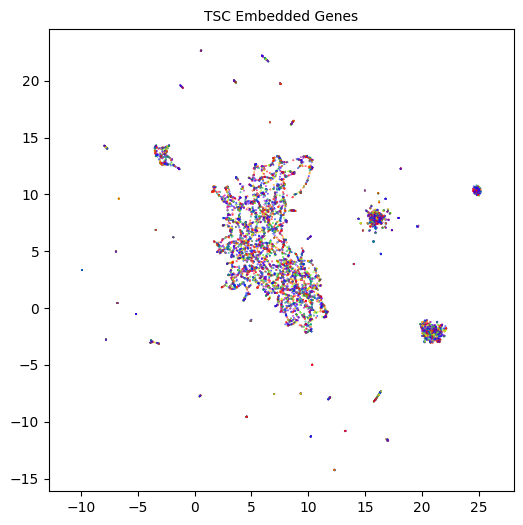

In [112]:
import matplotlib.pyplot as plt
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

cmap=discrete_cmap(16, 'prism')
#cmap = plt.get_cmap('tab20c')
Cs = gene_membership['module_id']
color_dict = {label: cmap(i%40) for i, label in enumerate(np.unique(Cs))}
colors = [color_dict[label] for label in Cs]


Xs= gene_membership['umap_1']
Ys= gene_membership['umap_2']

fig = plt.figure(figsize=(6, 6))
plt.scatter(Xs,Ys, s=.1, c= colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSC Embedded Genes', fontsize=10)


In [ ]:
with open("./ABM-MG-z.pk", 'rb') as f:
    z_ABM= pickle.load( f)
embedding_data = z_ABM